In [ ]:
# To push the split for training and developing data faster
# we need to skip the index when the timeline is not continuous. (This is covered by dropping all na values)
# The problem arise when there is not enough data after skipping.
# When that happen, the program skip again, leaving some valuable data behind.
# The best thing that can happen is when we skip the second time, if the timeline is not continuous, it will skip
# to the earliest not continous timeline. If we doesn't have any marker, we must find it manually by looping each index.
# So we need to have a marker. It will be put in the raw data files.

# Put timeskip marker in the raw datafiles. (New columns name Timeskip, value is the first time data appear again after the index)
# If after the skip, the timeline is not continous, find the time skip marker and put the position there.
# The refined file doesn't have data in PM (Missing data -> np.nan), findout why *** Not Done 2018 have some problem
# The split for training and developing data has index out of bound, fix it.
# The split for target have some difficulty:
# we can't shift the data so we have to merge it with splitting training data
# When splitting the data 


# We don't need to remove the data, we can just calculate like normal.
# Then in the finished file, we drop all data which deemed Missing. 
# When putting data to the model, we need to figure out a way to know which data is dropped


In [1]:
# !pip install --upgrade sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')

In [2]:
import pandas as pd
import numpy as np
import glob
import xarray as xr

idx = pd.IndexSlice

root_path = r'/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/'
_thudohanoi_data_path = r'/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data'
_thudohanoi_files = glob.glob(_thudohanoi_data_path + '/*.csv')

thudohanoi_df = pd.DataFrame()
for file in _thudohanoi_files:
    print('Currently processing file \n{}'.format(file))
    thudohanoi_df = thudohanoi_df.append(pd.read_csv(file, parse_dates=True, index_col=['site_id', 'time'],
                                                    dtype={'CO': np.float64, 'NO2': np.float64,'PM25': np.float64,
                                                          'AQI_h': np.float64, 'AQI_h_I': np.int, 'site_id': np.int}))
    
# Remove site 16 because of some inconsistency in data
thudohanoi_df = thudohanoi_df[(thudohanoi_df.index.get_level_values(0) != 49)]

Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/30.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/9.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/32.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/11.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/40.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/28.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/49.csv
Currently processing file 
/

In [72]:
x_test = thudohanoi_df[thudohanoi_df]
series_hanoi_train = series_hanoi[series_hanoi.index.year < 2019]

In [76]:
def add_features(series):
    # series = series.to_frame()
    series.reset_index(drop=False, inplace=True)

    window1 = 3
    window2 = 24
    window3 = 48
    feature = 'PM25'

    series_rolled_3d = series.rolling(window=window1, min_periods=0)
    series_rolled_7d = series.rolling(window=window2, min_periods=0)
    series_rolled_30d = series.rolling(window=window2, min_periods=0)

    series_mean_3d = series_rolled_3d.mean().shift(1).reset_index()
    series_mean_7d = series_rolled_7d.mean().shift(1).reset_index()
    series_mean_30d = series_rolled_30d.mean().shift(1).reset_index()

    series_std_3d = series_rolled_3d.std().shift(1).reset_index()
    series_std_7d = series_rolled_7d.std().shift(1).reset_index()
    series_std_30d = series_rolled_30d.std().shift(1).reset_index()

    series[f"{feature}_mean_lag{window1}"] = series_mean_3d['PM25']
    series[f"{feature}_mean_lag{window2}"] = series_mean_7d['PM25']
    series[f"{feature}_mean_lag{window3}"] = series_mean_30d['PM25']

    series[f"{feature}_std_lag{window1}"] = series_std_3d['PM25']
    series[f"{feature}_std_lag{window2}"] = series_std_7d['PM25']
    series[f"{feature}_std_lag{window3}"] = series_std_30d['PM25']

    series.fillna(series.mean(), inplace=True)

    series.set_index("Date (LT)", drop=False, inplace=True)
    
    series['Date (LT)'] = pd.to_datetime(series['Date (LT)'], format="%Y-%m-%d %H:%M:%S")
    series["month"] = series['Date (LT)'].dt.month
    series["hour_of_day"] = series['Date (LT)'].dt.hour
    series["day"] = series['Date (LT)'].dt.day
    series["day_of_week"] = series['Date (LT)'].dt.dayofweek
    
    
    return series

In [77]:
series_hanoi_valid = add_features(series_hanoi_valid)
series_hanoi_train = add_features(series_hanoi_train)
series_hcm = add_features(series_hcm)

<ipython-input-76-2d4519297c8d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[f"{feature}_mean_lag{window1}"] = series_mean_3d['PM25']
<ipython-input-76-2d4519297c8d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[f"{feature}_mean_lag{window2}"] = series_mean_7d['PM25']
<ipython-input-76-2d4519297c8d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

<a id="subsection-eight"></a>
# AUTO ARIMA

In [11]:
! pip install pmdarima
import pmdarima as pm

In [78]:
features = ['PM25_mean_lag3', 'PM25_mean_lag24',
       'PM25_mean_lag48', 'PM25_std_lag3', 'PM25_std_lag24', 'PM25_std_lag48',
       'month', 'hour_of_day', 'day', 'day_of_week']

In [48]:
df = series_hanoi

In [ ]:
df = series_hcm

In [83]:
series_hanoi_train = series_hanoi_train.drop(columns='Date (LT)')
series_hanoi_valid = series_hanoi_valid.drop(columns='Date (LT)')
series_hanoi_valid = series_hanoi_valid.dropna()

In [80]:
series_hanoi_train = df[df['Date (LT)'] < "2019"].drop(columns='Date (LT)')
series_hanoi_valid = df[df['Date (LT)'] >= "2019"].drop(columns='Date (LT)')
series_hanoi_valid = series_hanoi_valid.dropna()

KeyError: 'Date (LT)'

In [85]:
model_pmdarima = pm.auto_arima(series_hanoi_train.PM25, exogenous=series_hanoi_train[features], trace=True, error_action="ignore", suppress_warnings=True)
model_pmdarima.fit(series_hanoi_train.PM25, exogenous=series_hanoi_train[features])

forecast = model_pmdarima.predict(n_periods=len(series_hanoi_valid), exogenous=series_hanoi_valid[features])
series_hanoi_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=47.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=197387.111, Time=1.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=194922.329, Time=36.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=195117.027, Time=38.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=197385.115, Time=20.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=194897.013, Time=55.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=194825.396, Time=61.80 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=194703.885, Time=64.98 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=194676.185, Time=71.90 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=194203.926, Time=82.70 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=194164.160, Time=72.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=63.72 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=64.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=60.38 sec
 ARIMA(5,1,2)(0,0,0)

/home/nam/Development/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:xlabel='Date (LT)'>

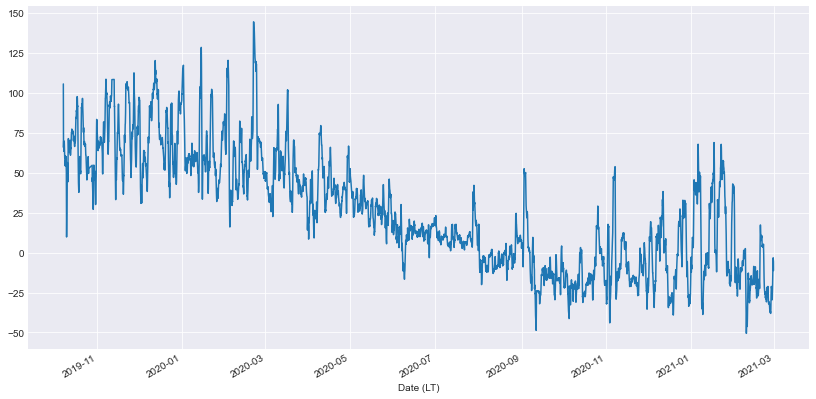

In [86]:
series_hanoi_valid["Forecast_ARIMAX"].plot(figsize=(14, 7))

<AxesSubplot:xlabel='Date (LT)'>

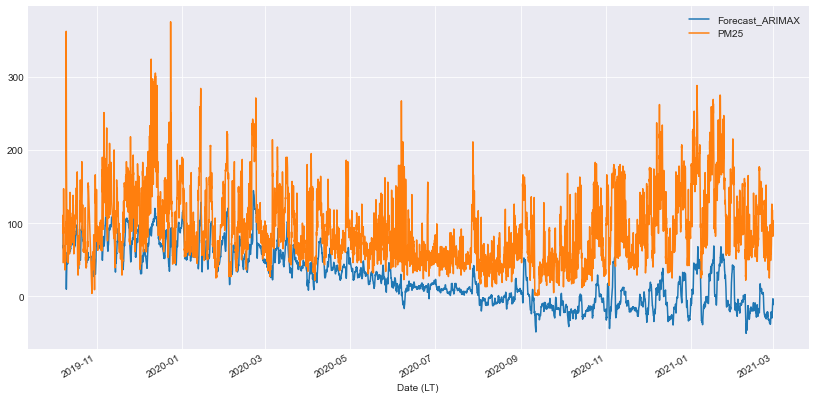

In [87]:
series_hanoi_valid[["Forecast_ARIMAX", "PM25"]].plot(figsize=(14, 7))

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_autoarima = sqrt(mean_squared_error(series_hanoi_valid['PM25'],series_hanoi_valid['Forecast_ARIMAX']))
# mape_autoarima = mean_absolute_percentage_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
mae_autoarima = mean_absolute_error(series_hanoi_valid['PM25'],series_hanoi_valid['Forecast_ARIMAX'])
print("RMSE: {} / MAE: {}".format(rmse_autoarima, mae_autoarima))

RMSE: 79.4145125515991 / MAE: 66.13702132721566


In [89]:
df_train = series_hanoi_train
df_valid = series_hanoi_valid

<a id="subsection-eight"></a>
# CART

In [90]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [91]:
tree_reg = tree.DecisionTreeRegressor()

In [92]:
X_train, y_train = df_train[features], df_train.PM25
X_test, y_test = df_valid[features], df_valid.PM25

In [93]:
## Hyper Parameter Optimization Grid

params={
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "min_samples_split": [1, 3, 4, 5, 6, 7],
 "min_samples_leaf" : [1, 3, 4, 5, 6, 7]
}

In [96]:
model_CART  = GridSearchCV(    
                tree_reg,
                param_grid=params,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [97]:
model_CART.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1065 out of 1080 | elapsed:   14.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   14.3s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 3, 4, 5, 6, 7],
                         'min_samples_split': [1, 3, 4, 5, 6, 7]},
             verbose=3)

In [98]:
print(f"Model Best Score : {model_CART.best_score_}")
print(f"Model Best Parameters : {model_CART.best_estimator_.get_params()}")

Model Best Score : 0.8674071493098487
Model Best Parameters : {'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 6, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


<AxesSubplot:xlabel='Date (LT)'>

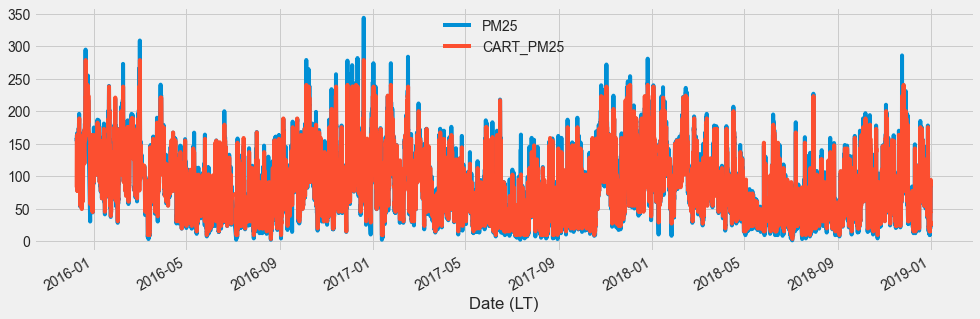

In [99]:
df_train['CART_PM25'] = model_CART.predict(X_train)

df_train[['PM25','CART_PM25']].plot(figsize=(15, 5))

<AxesSubplot:xlabel='Date (LT)'>

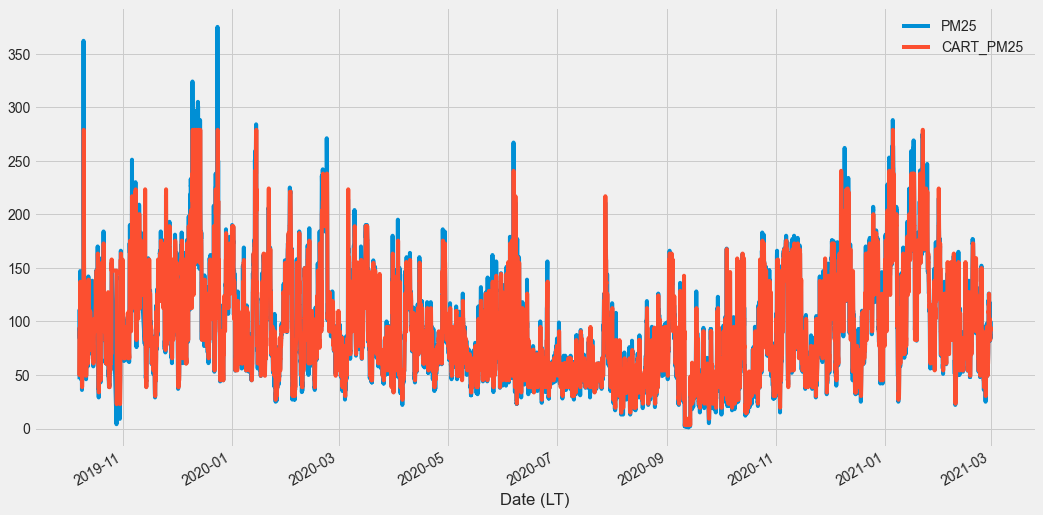

In [102]:
df_valid['CART_PM25'] = model_CART.predict(X_test)

df_valid[['PM25','CART_PM25']].plot(figsize=(16, 9))

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_tree = sqrt(mean_squared_error(df_valid['PM25'],df_valid['CART_PM25']))
# mape_autoarima = mean_absolute_percentage_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
mae_tree = mean_absolute_error(df_valid['PM25'],df_valid['CART_PM25'])
print("RMSE: {} / MAE: {}".format(rmse_tree, mae_tree))

RMSE: 16.102897333287846 / MAE: 10.679535362417356


<a id="subsection-eight"></a>
# XG Boost

In [110]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [105]:
reg = xgb.XGBRegressor()

In [106]:
X_train, y_train = df_train[features], df_train.PM25
X_test, y_test = df_valid[features], df_valid.PM25

In [107]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [108]:
model_xgboost  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [109]:
model_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 17107200 candidates, totalling 85536000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nam/Development/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 940, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/nam/Development/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/nam/Development/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 434, in result
    self._condition.wait(timeout)
  File "/home/nam/Development/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nam/Development/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/home/nam/Development/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_

TypeError: object of type 'NoneType' has no len()

In [ ]:
print(f"Model Best Score : {model_xgboost.best_score_}")
print(f"Model Best Parameters : {model_xgboost.best_estimator_.get_params()}")

In [ ]:
model_xgboost.best_estimator_

In [ ]:
df_train['Predicted_PM25'] = model_xgboost.predict(X_train)

df_train[['PM25','Predicted_PM25']].plot(figsize=(15, 5))

In [ ]:
df_valid['Predicted_PM25'] = model_xgboost.predict(X_test)
df_valid[['PM25', 'Predicted_PM25']].plot(figsize=(16,9))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_xgboost = sqrt(mean_squared_error(df_valid['PM25'],df_valid['Predicted_PM25']))
# mape_autoarima = mean_absolute_percentage_error(df_valid['PM25'],df_valid['Forecast_ARIMAX'])
mae_xgboost = mean_absolute_error(df_valid['PM25'],df_valid['Predicted_PM25'])
print("RMSE: {} / MAE: {}".format(rmse_xgboost, mae_xgboost))